In [318]:
import sys
import csv
import numpy as np
import pandas as pd
import math
from itertools import product
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler
from sklearn import linear_model, tree, grid_search
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from joblib import Parallel, delayed

le = preprocessing.LabelEncoder()

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

df  = pd.read_csv('dane_treningowe.csv')
final_df = pd.read_csv('dane_testowe.csv')

df = pd.concat([df, final_df])

def przerwa_transform(x):
    if x == 999:
        return 1
    if x < 3:
        return 0
    if x < 10:
        return 0.3
    return 0.6

def wiek_transform(x):
    if x >= 65:
        return 100
    if x < 22:
        return 18
    else:
        return int(math.ceil(x / 10.0)) * 10

def wyksztalcenie_transform(x):
    lista = [('illiterate',           1), 
             ('basic.4y',             0.5), 
             ('basic.6y',             0),
             ('basic.9y',             0.3),
             ('high.school',          0.6),
             ('unknown',              0.9),
             ('professional.course',  0.7),
             ('university.degree',    0.8)]

    for (a,b) in lista:
        if x == a:
            return b
    
    return -42

def zawod_transform(x):
    lista = [('unemployed',            0.8), 
             ('student',               1),
             ('housemaid',             0.2),
             ('services',              0.05),
             ('retired',               0.9),
             ('unknown',               0.3),
             ('blue-collar',           0),
             ('admin.',                0.7),
             ('technician',            0.5),
             ('self-employed',         0.6),
             ('entrepreneur',          0.1),
             ('management',            0.4)]

    for (a,b) in lista:
        if x == a:
            return b
    return -42
    

df['rezultat'] = df['rezultat'].map(lambda x: 1 if x == 'yes' else 0)
df['przerwa'] = df['przerwa'].map(przerwa_transform)
df['wyksztalcenie'] = df['wyksztalcenie'].map(wyksztalcenie_transform)
df['zawod'] = df['zawod'].map(zawod_transform)
df['wiek']  = df['wiek'].map(wiek_transform)

parameters_to_num = ['stan_cywilny', 'debet', 'hipoteka', 'pozyczka', 'poprzedni_wynik']

for p in parameters_to_num:
    df[p] = le.fit_transform(df[p])
    


def scale():
    for col in list(df.columns.values):
        if col != 'rezultat' and col != 'id_klienta' and col != 'EURIBOR3M':
            df[col] = MinMaxScaler().fit_transform(df[col])
        
scale()

final_df = df[28000:]
df = df[:27999]

np.random.randn(42)
msk = np.random.rand(len(df)) < 0.8

train_df = df[msk]
test_df  = df[~msk]


def preprocess(_df):
    _df = _df.drop('CCI', axis=1)
    _df = _df.drop('pozyczka', axis=1)
    _df = _df.drop('hipoteka', axis=1)
    
    if 'rezultat' in _df:
        X = _df.drop('rezultat', axis=1)
        Y = _df['rezultat']
    else:
        X = _df
        Y = _df
    return (X,Y)

def train_test_score(clf):
    test_P = clf.predict(test_X)
    train_P = clf.predict(train_X)
    fpr, tpr, thresholds = metrics.roc_curve(test_Y, test_P, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    
    f1 = f1_score(test_Y, test_P)
    f2 = f1_score(train_Y, train_P)
    return (f1, f2)
    
def score_raw_score(test_P, train_P, test_PP):
    fpr, tpr, thresholds = metrics.roc_curve(test_Y, test_PP, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    
    f1 = f1_score(test_Y, test_P)
    f1_train = f1_score(train_Y, train_P)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    title = "ROC Curve. AUC = " + str(auc) + " F1 TEST = " + str(f1) + "F1 TRAIN = " + str(f1_train)
    plt.title(title)
    plt.show()
    target_names = ['NIE', 'TAK']
    print(metrics.classification_report(test_Y, test_P, target_names=target_names))


def score_classifier(clf):
    test_P = clf.predict(test_X)
    train_P = clf.predict(train_X)
    test_PP = clf.predict_proba(test_X)
    score_raw_score(test_P, train_P, test_PP[:,1])

def score_function(func):
    test_P = map((lambda x: 1 if x>0.9 else 0), func(test_X))
    train_P = map((lambda x: 1 if x>0.9 else 0), func(train_X))
    test_PP = func(test_X)
    score_raw_score(test_P, train_P, test_PP)
    

(train_X, train_Y) = preprocess(train_df)
(test_X, test_Y)   = preprocess(test_df)
(final_X, _)       = preprocess(final_df)

In [306]:
answers = []
column = 'zawod'

for zawod in df[column].unique():
    df2 = df[df[column] == zawod]
    rez = float(df2[df2['rezultat'] == 1].count()['rezultat']) / df2.count()['rezultat'] * 100
    answers.append ((rez, "i = "  + str(zawod) + " rez = " + str(rez)  + "%" + " support: " + str(df2.count()[0])))

for (a,b) in sorted(answers):
    print b

i = 0.0 rez = 7.02936928262% support: 6231
i = 0.05 rez = 8.0073800738% support: 2710
i = 0.1 rez = 8.77016129032% support: 992
i = 0.2 rez = 9.30555555556% support: 720
i = 0.3 rez = 10.1851851852% support: 216
i = 0.4 rez = 10.8597285068% support: 1989
i = 0.5 rez = 11.004784689% support: 4598
i = 0.6 rez = 11.0204081633% support: 980
i = 0.7 rez = 12.940845862% support: 7117
i = 0.8 rez = 14.8305084746% support: 708
i = 0.9 rez = 25.4716981132% support: 1166
i = 1.0 rez = 32.3426573427% support: 572


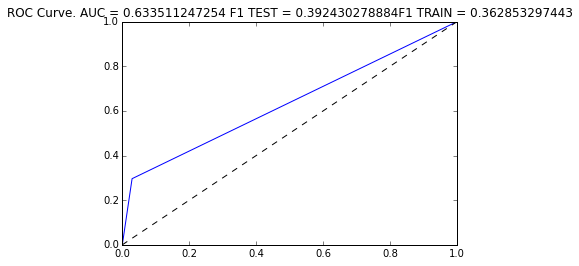

             precision    recall  f1-score   support

        NIE       0.91      0.97      0.94      4860
        TAK       0.58      0.30      0.39       665

avg / total       0.87      0.89      0.87      5525



In [303]:
def classify(X):
    ret = []
    for (i, example) in X.iterrows():
        ans = 0.0
        if example['EURIBOR3M'] == 0.697:
            ans = 1.0
        if example['wiek'] > 0.6:
            ans = 1.0
        if example['przerwa'] < 0.7:
            ans = 1.0
        ret.append(ans)
    return ret
score_function(classify)

Analiza danych
--------------

In [242]:
df2 = df.corr()
df2['rezultat'].sort_values()

wskaznik_zatrudnienia    -0.357736
przerwa                  -0.327776
EURIBOR3M                -0.310189
zmiennosc_zatrudnienia   -0.297674
CPI                      -0.130332
debet                    -0.101494
liczba_kontaktow         -0.067012
pozyczka                 -0.002856
id_klienta                0.010694
hipoteka                  0.014822
stan_cywilny              0.044312
CCI                       0.049440
wiek                      0.057060
wyksztalcenie             0.064604
zawod                     0.123764
poprzedni_wynik           0.135677
poprzednie                0.238839
rezultat                  1.000000
Name: rezultat, dtype: float64

Łatwo zauważyć, że szczególnie istotne parametry które w liniowy sposób wpływają na wynik to odpowiednio
* wskaźnik_zatrudnienia (35%)
* przerwa (33%)
* EURIBOR3m (31%)
* zmiennosc_zatrudnienia (29%)
* poprzednie (23%)
* poprzednie_wynik (13%)
* CPI (13%)
* debet (10%)

Dodatkowo warto zauważyć, że wysoki wpływ wskaźników EURIBOR3M, CPI, wskaźnik_zatrudnienia oraz zmienność_zatrudnienia wynika z tego, że każdy z nich niesie informacje o tym, w jakim dniu został nawiązany kontakt z klientem. Z konkretnym okresem może być związanych dużo innych zdarzeń, w szczególności wyjątkowe promocje, oferty czy kampanie reklamowe.

Algorytm
---------

Sprawdzam, czy istnieje korelacja między klasą decyzyjną a pozostałymi kolumnami zbioru danych

Na podstawie powyższej tabelki można stwierdzić, iż istnieje statystycznie istotna korelacja między wartościami w kolumnach C* a wartością klasy decyzyjnej

Następnie sprawdzam korelacje między kolumnami C*

Tym razem możemy stwierdzić brak statystycznie istotnej korelacji między kolumnami. Wobec tego, użycie klasyfikatora działającego liniowo względem danych powinno być wystarczające.



Następnie sprawdzam liczność klasy decyzyjnych z "1" oraz "0"

Ponieważ rozkład "1" oraz "0" w klasie decyzyjnej jest równomierny, nie jest konieczne użycie F-Score do wyznacznia dokładności klasyfikatora, wystarczy policzyć precyzję na zbiorze testowym

----------------------------------------------------

Poniżej przedstawiam przebieg i wyniki badań. GridSearchCV jest funkcją, która automatycznie dopasowuje najlepsze parametry z podanych list na podstawie wyniku na walidacji krzyżowej.

Jakość ostatecznego wyniku dla każdego z algorytmów zbadałem na zbiorze testowym.

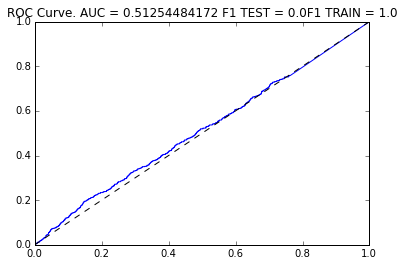

             precision    recall  f1-score   support

        NIE       0.89      1.00      0.94      4924
        TAK       0.00      0.00      0.00       637

avg / total       0.78      0.88      0.83      5561



In [286]:
#train_X = train_X[['wskaznik_zatrudnienia', 'EURIBOR3M']]
#test_X = test_X[['wskaznik_zatrudnienia', 'EURIBOR3M']]

knc = KNeighborsClassifier(n_neighbors = 12, weights='distance', algorithm='brute')
knc.fit(train_X, train_Y)
score_classifier(knc)

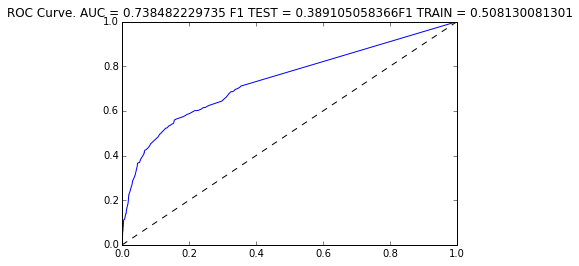

             precision    recall  f1-score   support

        NIE       0.92      0.96      0.94      4924
        TAK       0.51      0.31      0.39       637

avg / total       0.87      0.89      0.87      5561



In [287]:
dtc = tree.DecisionTreeClassifier()

parameters = {
    'max_depth': (25,50,75,100,200, 500),
    'min_samples_split': (5, 6,7,8, 15),
    'min_samples_leaf': (5,7,8,9,10, 20)
}

clf = grid_search.GridSearchCV(dtc, parameters, n_jobs=-1, scoring='f1')
clf.fit(train_X, train_Y)
score_classifier(clf)

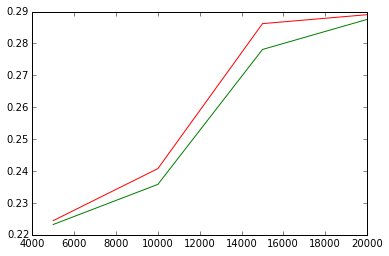

In [319]:
test_X = test_X[['przerwa', 'wiek', 'EURIBOR3M']]
train_X = train_X[['przerwa', 'wiek', 'EURIBOR3M']]

def licz(nte, sd):
    mlp = MLPClassifier(max_iter=2000, random_state = sd)
    parameters = {'hidden_layer_sizes':(7,8)}
    clf = grid_search.GridSearchCV(mlp, parameters, n_jobs=2, scoring='f1')
    clf.fit(train_X[1:nte], train_Y[1:nte])
    return train_test_score(clf)

result_i   = []
result_auc = []
result_aac = []

for num in [5000, 10000, 15000, 20000]:
    ans_acc  = 0
    test_acc = 0
    res = Parallel(n_jobs=6)(delayed(licz)(num, (i)) for i in range(10))
    
    ans_acc = 0
    test_acc = 0
    for a, b in res:
        ans_acc += a
        test_acc += b
        
    result_i.append(num)
    result_auc.append(ans_acc/10)
    result_aac.append(test_acc/10)

plt.plot(result_i, result_auc, 'g', result_i, result_aac, 'r')

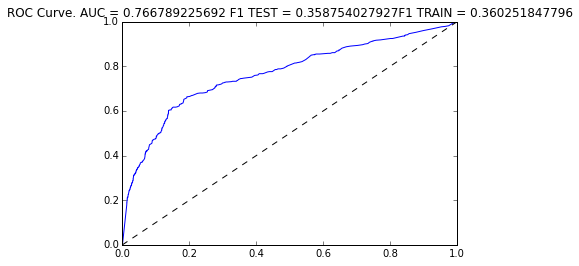

             precision    recall  f1-score   support

        NIE       0.91      0.98      0.94      4941
        TAK       0.59      0.26      0.36       647

avg / total       0.87      0.89      0.87      5588



In [320]:
#test_X = test_X[['przerwa', 'wiek', 'EURIBOR3M']]
#train_X = train_X[['przerwa', 'wiek', 'EURIBOR3M']]
knc = GaussianNB()
knc.fit(train_X, train_Y)
score_classifier(knc)

Podsumowanie
------------

Jak wynika z poniższej tabelki, najlepszy wynik spośród sprawdzonych algorytmów można uzyskać stosując sieć neuronową o 10 warstwach ukrytych i jest to 89.7%. Z poznanych do tej pory algorymtów najlepiej sprawdził się algorytm Naive Bayes z dokładnością klasyfikacji 86.4%.

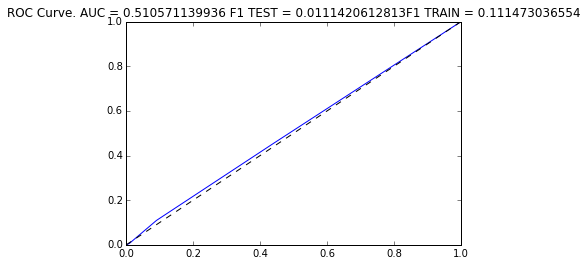

             precision    recall  f1-score   support

        NIE       0.88      0.99      0.93      4982
        TAK       0.08      0.01      0.01       668

avg / total       0.79      0.87      0.82      5650



In [235]:
knc = KNeighborsClassifier(weights='uniform', algorithm='brute')
knc.fit(train_X, train_Y)
score_classifier(knc)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.0s finished


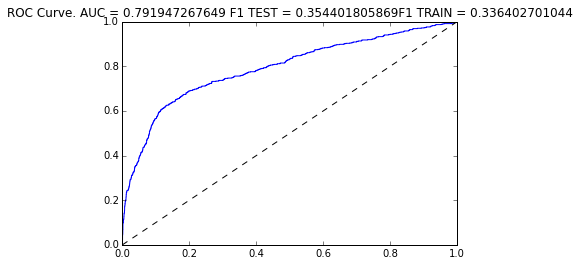

             precision    recall  f1-score   support

        NIE       0.91      0.99      0.95      4982
        TAK       0.72      0.24      0.35       668

avg / total       0.88      0.90      0.88      5650



In [234]:
dtc = RandomForestClassifier(max_depth=40, min_samples_leaf = 24, max_features= 5 ,n_estimators=500, oob_score = True)
parameters = {
    #'max_depth':range(30,50,5),
    #'min_samples_leaf':range(15,25,3),
    #'max_features': range(2,6)
}
clf = grid_search.GridSearchCV(dtc, parameters, n_jobs=-1, scoring='f1', verbose=True)
clf.fit(train_X, train_Y)
score_classifier(clf)

Parametry najlepszego klasyfikatora według wyników crossvalidation

In [239]:
clf.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=25,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=20,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Wskaźnik ważności poszczególnych feature w zastosowanym algorytmie

In [240]:
i = 0
lista = []
for col in list(train_X.columns.values):
    lista.append((clf.best_estimator_.feature_importances_[i], str(col) + " " + str(clf.best_estimator_.feature_importances_[i])))
    i+=1
    
for (a,b) in sorted(lista):
    print b

zmiennosc_zatrudnienia 0.0
debet 0.00303190843653
CPI 0.00701536520499
poprzednie 0.0102954044628
stan_cywilny 0.0113837406205
wiek 0.0162826201901
wyksztalcenie 0.0223268528341
liczba_kontaktow 0.0238465628411
poprzedni_wynik 0.0242505056588
zawod 0.0421780059881
przerwa 0.0924711693349
id_klienta 0.118000267059
EURIBOR3M 0.148171138795
wskaznik_zatrudnienia 0.480746458574


In [203]:
arr = clf.predict_proba(final_X)
ids = final_X['id_klienta']

np.set_printoptions(threshold='nan')
len(arr[arr[:,1] > 0.3781])
for i in range(0, 13188):
    if (arr[i,1] > 0.3781):
        print ids[i]

38008
38015
38016
38033
38041
38058
38062
38068
38072
38093
38112
38119
38148
38161
38167
38213
38214
38217
38252
38295
38301
38318
38331
38349
38353
38358
38370
38371
38381
38394
38421
38424
38426
38433
38440
38454
38465
38530
38575
38578
38596
38599
38660
38681
38683
38690
38693
38713
38723
38757
38773
38775
38776
38787
38798
38809
38812
38855
38862
38870
38873
38874
38878
38881
38920
38936
38947
38973
38975
38994
39022
39040
39052
39058
39064
39078
39092
39123
39124
39135
39141
39159
39164
39169
39198
39239
39249
39259
39316
39326
39330
39362
39364
39366
39373
39384
39389
39397
39426
39427
39430
39434
39437
39459
39467
39475
39479
39511
39526
39580
39610
39636
39651
39657
39665
39679
39699
39722
39729
39730
39740
39745
39774
39775
39809
39815
39820
39821
39827
39842
39846
39851
39878
39917
39928
39969
39974
39981
39991
39995
39999
40006
40011
40019
40037
40039
40056
40099
40108
40112
40114
40124
40138
40141
40158
40169
40182
40188
40192
40203
40221
40248
40257
40258
40261
40268
4027